## verify S2S prediction skill
- verity using Brier Skill score
- utilize `climpred`


In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from climpred import HindcastEnsemble,PerfectModelEnsemble
import climpred
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Read in observations and S2S

In [3]:
ds = xr.open_mfdataset('/glade/work/huili7/S2S/forecast_files_byweek/forecast_obs_persist_count*.nc',
                      combine='nested',concat_dim='forecast_n')

In [4]:
date_rng = pd.date_range('20020101','20191231',freq='1D')
init_date = date_rng.where(date_rng.dayofweek==0).dropna()
init_date1 = pd.Series(init_date.format()).array

In [5]:
init_date

DatetimeIndex(['2002-01-07', '2002-01-14', '2002-01-21', '2002-01-28',
               '2002-02-04', '2002-02-11', '2002-02-18', '2002-02-25',
               '2002-03-04', '2002-03-11',
               ...
               '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18',
               '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16',
               '2019-12-23', '2019-12-30'],
              dtype='datetime64[ns]', length=939, freq=None)

In [6]:
obs = ds.forecast

obs =obs.rename({'week':'lead'})

obs = obs.rename({'forecast_n':'init'})
obs

<xarray.DataArray 'forecast' (lead: 6, basin: 6, init: 939)>
dask.array<concatenate, shape=(6, 6, 939), dtype=float64, chunksize=(6, 6, 53), chunktype=numpy.ndarray>
Dimensions without coordinates: lead, basin, init

In [7]:
obs = ds.forecast
obs = obs.rename({'forecast_n':'init'}) 
obs = obs.rename({'week':'lead'})

In [8]:
obs['init'] = init_date
obs = obs.assign_coords(lead=np.arange(1,7))
obs['lead'].attrs['units']='weeks'
obs= obs.assign_coords(basin = ['at','ep','ni','nwp','sh','global'])

read in hindcast data

In [9]:
ds = xr.open_mfdataset('/glade/work/huili7/S2S/forecast_files_byweek/forecast_skill*raw.nc',
                      combine='nested',concat_dim='forecast_n')

In [10]:
forecast = ds.forecast

In [11]:
forecast = forecast.rename({'forecast_n':'init'})

forecast['init'] = init_date
forecast = forecast.rename({'week':'lead'})
forecast['lead'].attrs['units']='weeks'
forecast = forecast.assign_coords(basin = ['at','ep','ni','nwp','sh','global'])
forecast['member'] = np.arange(1,12)

## 2. Make the forecast binary

In [12]:
obs = obs.where(obs==0,1)

In [13]:
forecast = forecast.where(forecast==0,1)

## 3.Filter data to only retain TC season in each basin


### 3.1 trim S2S by TC season in each basin

In [14]:
# define TC season in each basin
month_at= [5,6,7,8,9,10,11]
month_ep = [5,6,7,8,9,10]
month_ni = [4,5,6,9,10,11]
month_nwp = [4,5,6,7,8,9,10,11]
month_sh = [1,2,3,4,10,11,12]

In [15]:
month_basin = [month_at,month_ep,month_ni,month_nwp,month_sh]
month_basin

[[5, 6, 7, 8, 9, 10, 11],
 [5, 6, 7, 8, 9, 10],
 [4, 5, 6, 9, 10, 11],
 [4, 5, 6, 7, 8, 9, 10, 11],
 [1, 2, 3, 4, 10, 11, 12]]

In [16]:
# only consider TC season, make all other months zero
# atlantic basin
for ib in np.arange(0,5):  #basin
    for i in np.arange(0,6): #lead
        f_date = forecast.init + np.timedelta64(i,'W')
        forecast[i,ib,:,:] = forecast.isel(basin=ib,lead=i).where(f_date.dt.month.isin(month_basin[ib]))
        obs[i,ib,:] = obs.isel(basin=ib,lead=i).where(f_date.dt.month.isin(month_basin[ib]))

### 3.2  trim observations 

In [17]:
# obs_at = obs.isel(basin=0)
# obs_at = obs_at.where(obs_at.time.dt.month.isin(month_at),0)

# obs_ep = obs.isel(basin=1)
# obs_ep = obs_ep.where(obs_ep.time.dt.month.isin(month_ep),0)

# obs_ni = obs.isel(basin=2)
# obs_ni = obs_ni.where(obs_ni.time.dt.month.isin(month_ni),0)

# obs_nwp = obs.isel(basin=3)
# obs_nwp = obs_nwp.where(obs_nwp.time.dt.month.isin(month_nwp),0)

# obs_sh = obs.isel(basin=4)
# obs_sh = obs_sh.where(obs_sh.time.dt.month.isin(month_sh),0)

## 4. Create forecast ensemble for each basin

In [18]:
# hindcast = HindcastEnsemble(forecast)

# hindcast_at = hindcast.mean('member').isel(basin=0)
# hindcast_at = hindcast_at.add_observations(obs_at)

# hindcast_ep = hindcast.mean('member').isel(basin=1)
# hindcast_ep = hindcast_ep.add_observations(obs_ep)

# hindcast_ni = hindcast.mean('member').isel(basin=2)
# hindcast_ni = hindcast_ni.add_observations(obs_ni)

# hindcast_nwp = hindcast.mean('member').isel(basin=3)
# hindcast_nwp = hindcast_nwp.add_observations(obs_nwp)

# hindcast_sh = hindcast.mean('member').isel(basin=4)
# hindcast_sh = hindcast_sh.add_observations(obs_sh)

# hindcast_nwp.plot()

## 5. Verity using Brier Score

### 5.1 get BS of S2S

**note**: week1 has prexisting storms

since week1 need to be compared with a different observation, we don't use the climpred package

In [19]:
# get ensemble mean
forecast_m= forecast.mean('member')

In [20]:
forecast_m

<xarray.DataArray 'forecast' (lead: 6, basin: 6, init: 939)>
dask.array<mean_agg-aggregate, shape=(6, 6, 939), dtype=float64, chunksize=(6, 6, 53), chunktype=numpy.ndarray>
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6
  * init     (init) datetime64[ns] 2002-01-07 2002-01-14 ... 2019-12-30
  * basin    (basin) <U6 'at' 'ep' 'ni' 'nwp' 'sh' 'global'

In [21]:
bs = (forecast_m - obs) **2
bs = bs.mean('init')

In [22]:
bs.isel(basin=0).compute()

<xarray.DataArray 'forecast' (lead: 6)>
array([0.22907164, 0.23108883, 0.24090382, 0.27370576, 0.27329931,
       0.27266706])
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6
    basin    <U6 'at'

### 5.2 get reference brier score

- annual mean constant 

In [23]:
ds = xr.open_mfdataset('/glade/work/huili7/S2S/forecast_files_byweek/forecast_obs_count*.nc',
                      combine='nested',concat_dim='forecast_n')

In [24]:
obs_ref  = ds.forecast

In [25]:
obs_ref  =obs_ref.rename({'forecast_n':'init'})
obs_ref = obs_ref.rename({'week':'lead'})
obs_ref['init'] = init_date

In [26]:
obs_ref = obs_ref.isel(lead=0)

In [27]:
obs_ref = obs_ref.where(obs_ref==0, 1)

In [28]:
# TC season in each basin
obs_ref[0,:] = obs_ref.isel(basin=0).where(obs_ref.init.dt.month.isin(month_at))
obs_ref[1,:] = obs_ref.isel(basin=1).where(obs_ref.init.dt.month.isin(month_ep))
obs_ref[2,:] = obs_ref.isel(basin=2).where(obs_ref.init.dt.month.isin(month_ni))
obs_ref[3,:] = obs_ref.isel(basin=3).where(obs_ref.init.dt.month.isin(month_nwp))
obs_ref[4,:] = obs_ref.isel(basin=4).where(obs_ref.init.dt.month.isin(month_sh))

In [29]:
ann_mean_forecast = obs_ref.mean('init').compute()

In [30]:
bs_ref = (ann_mean_forecast - obs) **2
bs_ref = bs_ref.mean('init')

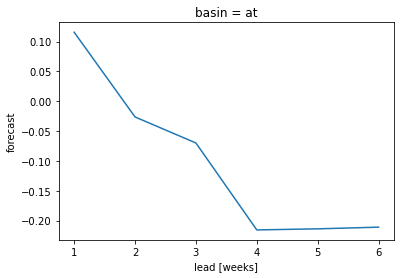

In [31]:
BSS = 1 - (bs / bs_ref)
BSS.isel(basin=0).plot()

- monthly varying reference

In [32]:
mon_clim = obs_ref.groupby(obs_ref.init.dt.month).mean('init')
mon_clim['basin']  = obs['basin']

In [33]:
mon_mean_forecast = forecast_m.copy(data=np.zeros(forecast_m.shape))


In [34]:
for i in np.arange(0,6): # lead
    f_date = forecast.init + np.timedelta64(i,'W')
    for ib in np.arange(0,6):
        for im in np.arange(1,13):
            mon_mean_forecast[i,ib,:] = xr.where(f_date.dt.month==im, mon_clim.sel(month=im, basin=mon_clim['basin'][ib]).values,mon_mean_forecast[i,ib,:])
            
            
            

In [35]:
mon_mean_forecast

<xarray.DataArray 'forecast' (lead: 6, basin: 6, init: 939)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.73417722, 0.73417722, 0.73417722, ..., 0.51851852,
         0.51851852, 0.51851852],
        [0.7721519 , 0.7721519 , 0.7721519 , ..., 0.77777778,
         0.77777778, 0.77777778]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
...
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.71232877, 0.71232877, 0.71232877, ..., 0.73417722,
         0.73417722, 0.73417722],
        [0.73972603, 0.73972603, 0.73972603, ..., 0.7721519 ,
         0.7721519 , 0.7721519 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.71232877, 0.71232877, 0.71232877, ..., 0.73417722,
         0.73417722, 0.71232877],
        [0.73972603, 0.73972603, 0.73972603, ..., 0.7721519 ,
         0.7721519 , 0.73972603]]])
Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6
  * init     (init) datetime64[ns] 2002-01-07 2002-01-14 ... 2019-12-30
  * basin    (basin) <U6 'at' 'ep' 'ni' 'nwp' 'sh' 'global'

In [36]:
bs_ref_m = (mon_mean_forecast - obs) **2
bs_ref_m = bs_ref_m.mean('init')

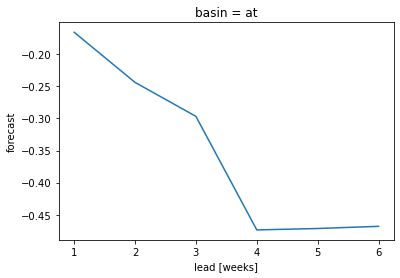

In [37]:
BSS_m = 1 - (bs / bs_ref_m)
BSS_m.isel(basin=0).plot()

In [38]:
obs['basin'].values[0].astype(str).upper()

'AT'

## potential predicatability
- chose each model as the observation and use the rest of the model as prediction

In [39]:
# open forecast file where lead=week2-6 are filled with values from week1
# this is used as the "perfect model"
dp = xr.open_mfdataset('/glade/work/huili7/S2S/forecast_files_byweek/forecast_skill_count_*potential.nc',
                                           combine='nested',concat_dim='forecast_n')

In [40]:
fp = dp.forecast

In [41]:
fp = fp.rename({'forecast_n':'init'})

fp['init'] = init_date
fp = fp.rename({'week':'lead'})
fp['lead'].attrs['units']='weeks'
fp = fp.assign_coords(basin = ['at','ep','ni','nwp','sh','global'])
fp['member'] = np.arange(1,12)

In [42]:
fp = fp.where(fp==0,1)

In [43]:
# only consider TC season, make all other months zero
# atlantic basin
for ib in np.arange(0,5):  #basin
    for i in np.arange(0,6): #lead
        f_date = forecast.init + np.timedelta64(i,'W')
        fp[i,ib,:,:] = fp.isel(basin=ib,lead=i).where(f_date.dt.month.isin(month_basin[ib]))


In [44]:
# calculate Brier Score
BSS_p = []
for im in np.arange(1,12):
    ref = fp.sel(member=im)
    hindcast = forecast.drop_sel(member=im).mean('member')
    
    bsp = (hindcast - ref) **2
    bsp = bsp.mean('init')
    bsp =  1 - (bsp / bs_ref_m)
    BSS_p.append(bsp)

In [45]:
BSS_p = xr.concat(BSS_p,dim='member')

In [46]:
# average over each perfect model forecast
BSS_p = BSS_p.mean('member')

In [ ]:
# Alternative method using climpred
# for each ensemble member, have a hindcast ensemble, calculate BS
# then take the average
# BSS_p = []
# for im in np.arange(1,12):
#     hindcast = HindcastEnsemble(forecast.drop_sel(member=im)).mean('member')
#     hindcast = hindcast.add_observations(forecast.sel(member=im,lead=1).rename({'init':'time'}))
#     hindcast = hindcast.verify(metric='brier_score',
#         comparison='e2o', dim=['init'], alignment='same_verif')
#     BS_p =  1 - (hindcast.forecast/ bs_ref_m)
#     BSS_p.append(BS_p)

## horray. Now let's plot

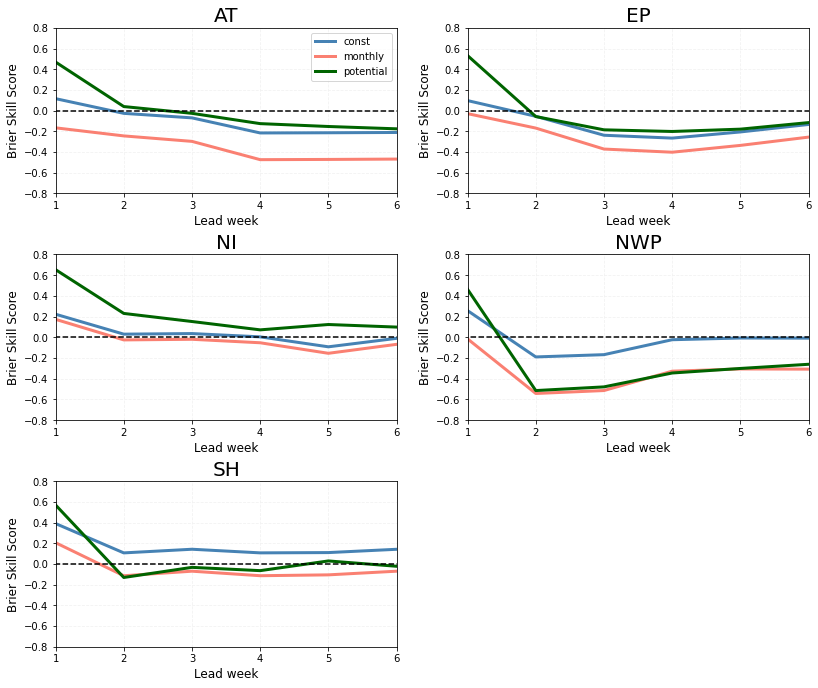

In [57]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.tight_layout(pad=4)

axs = axs.flatten()

for ib in np.arange(0,5):
    BSS.isel(basin=ib).plot(ax = axs[ib],label ='const',color='steelblue',linewidth = 3)
    BSS_m.isel(basin=ib).plot(ax = axs[ib],label ='monthly',color='salmon',linewidth=3)
    BSS_p.isel(basin=ib).plot(ax= axs[ib],label='potential',color='darkgreen',linewidth=3)
    axs[ib].plot(np.arange(0,8),np.zeros(8),color='black',linestyle='--')
    axs[ib].set_ylim(-0.8, 0.8)
    axs[ib].grid(color='0.95', linestyle='--')
    axs[ib].set_xlim(1,6)
    
    axs[ib].set_ylabel("Brier Skill Score",fontsize=12)
    axs[ib].set_xlabel("Lead week",fontsize=12)
    axs[ib].set_title(obs['basin'].values[ib].astype(str).upper(),fontsize=20)
    axs[ib].set_xticks(np.arange(1, 7))

# plt.subplots_adjust(top=0.85)
axs[0].legend()
axs[-1].axis('off')

plt.show()